# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. 

Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

In [214]:
#Стандартные библиотеки
import pandas as pd
import numpy as np
#Библитоки для постороения графиков
import seaborn as sns
from matplotlib import pyplot as plt
#библитоки для построенния матриц корреляции
import phik
from phik.report import plot_correlation_matrix
from phik import report
#все что нам может понадобится для построение пайплайна
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
#наши модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#дополнительные библитеки/глобальные переменные
from skimpy import clean_columns
RANDOM_STATE = 300924
TEST_SIZE = 0.25
pd.set_option('display.max_colwidth', 100)

In [145]:
def hist_box_plot(data, columns):
    plt.figure(figsize=(10, 4* len(columns)))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 2, 2*i + 1)
        data[col].hist(bins=15)
        plt.title(f'Гистограмма | {col}')
        plt.xlabel(f'{col}')
        plt.ylabel(f'\n Частота')

        plt.subplot(len(columns), 2, 2*i + 2)
        data.boxplot(column=col)
        plt.title(f'Ящик с усами | {col}')

In [146]:
def still_active(date):
    if date == 'No':
        return 0
    else:
        return 1

## Загрузка данных

In [147]:
try:
    data_phone = pd.read_csv('phone_new.csv')
    data_internet = pd.read_csv('internet_new.csv')
    data_personal = pd.read_csv('personal_new.csv')
    data_contract = pd.read_csv('contract_new.csv')
except:
    data_phone = pd.read_csv('/datasets/phone_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_contract = pd.read_csv('/datasets/contract_new.csv')

In [148]:
data_phone.sample(5)

,customerID,MultipleLines
4820,1470-PSXNM,Yes
1504,8580-AECUZ,No
3887,1506-YJTYT,Yes
233,0123-CRBRT,Yes
5395,5995-OIGLP,No


In [149]:
data_phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [150]:
data_internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3056,2139-FQHLM,Fiber optic,No,No,Yes,Yes,Yes,No
3372,8413-YNHNV,DSL,Yes,Yes,Yes,Yes,Yes,Yes
4637,7240-ETPTR,DSL,No,No,Yes,No,Yes,Yes
2879,4433-JCGCG,Fiber optic,No,No,Yes,No,Yes,Yes
1715,1136-XGEQU,DSL,No,Yes,Yes,Yes,Yes,Yes


In [151]:
data_internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [152]:
data_personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
6187,0224-NIJLP,Male,0,Yes,Yes
3958,4652-NNHNY,Male,0,Yes,No
1029,4184-TJFAN,Female,1,Yes,Yes
1875,9637-CDTKZ,Male,0,Yes,No
351,5160-UXJED,Male,0,No,Yes


In [153]:
data_personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [154]:
data_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2628,2792-LSHWX,2020-01-01,No,Month-to-month,Yes,Mailed check,83.40,83.4
2700,2346-DJQTB,2017-03-01,No,Month-to-month,No,Electronic check,24.15,845.25
5063,3744-ZRRDZ,2018-04-01,No,Month-to-month,Yes,Electronic check,82.35,1811.7
1618,8017-LXHFA,2018-02-01,No,Month-to-month,Yes,Electronic check,94.75,2274.0
5437,7000-WCEVQ,2018-05-01,No,Month-to-month,Yes,Mailed check,61.60,1358.28


In [155]:
data_contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

##  Исследовательский анализ и предобработка данных

In [156]:
data_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [157]:
data_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [158]:
data_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [159]:
data_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


### Промежуточный вывод

Из подсказки которую мы получили знаем что пропусков нет.

Единственное что после загрузки данных можно сказать что столбец "customerID" во всех таблицах не змеинном стиле мы его переименную полсе объелниения таблиц. Тоже самое касается и всех остальных столбцов например MonthlyCharges когда должно быть monthly_charges

## Объединение данных

In [160]:
data = data_contract.merge(data_personal, how='left', on='customerID') \
    .merge(data_internet, how='left', on='customerID') \
    .merge(data_phone, how='left', on='customerID')

In [161]:
data.shape

(7043, 20)

In [162]:
data.customerID.is_unique

True

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Заполним пропуски столбцов которые вышли из таблицы internet значением -1 тк если там есть пропушенные значения значит пользователь пользуется только услугами телефонии

In [164]:
internet = data_internet.columns.to_list()
internet.remove('customerID')
internet.remove('InternetService')

In [165]:
for i in internet:
    data[i].fillna('-1', inplace = True)

C:\Users\admin\AppData\Local\Temp\ipykernel_8544\3873706247.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[i].fillna('-1', inplace = True)


Поскольку мы знаем что пустые значения = телефония по этому заменим пустые значения интернет сервиса на phone

In [166]:
data['InternetService'].fillna('phone', inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_8544\677528824.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['InternetService'].fillna('phone', inplace=True)


Теперь сделаем тоже самое только для столбца MultipleLines и заменим на -1 чтобы было понятно что это пользователи интернет услуг

In [167]:
data['MultipleLines'].fillna('-1', inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_8544\1570488065.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['MultipleLines'].fillna('-1', inplace=True)


In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


### Привидем к змеиным нормам

In [169]:
data = clean_columns(data)

In [170]:
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

In [172]:
data = data.set_index('customer_id')

### Выделим целевой признак still_active

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv  

In [174]:
data['still_active'] = data['end_date'].apply(still_active)

In [175]:
data.end_date.unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Заменим значения нет на послежднее актуальное значение 2020-01-01

In [176]:
data.end_date = data.end_date.replace(['No'], ['2020-02-01'])
data.end_date = pd.to_datetime(data.end_date, format='%Y-%m-%d')

In [177]:
data.end_date.sample(10)

customer_id
4745-LSPLO   2020-02-01
7739-LAXOG   2019-06-01
4160-AMJTL   2020-02-01
5930-GBIWP   2017-03-01
2926-JEJJC   2020-02-01
2162-FRZAA   2020-02-01
3930-ZGWVE   2020-02-01
2632-TACXW   2017-06-01
8595-SIZNC   2020-02-01
2097-YVPKN   2019-01-01
Name: end_date, dtype: datetime64[ns]

In [178]:
data.begin_date = pd.to_datetime(data.begin_date, format='%Y-%m-%d')

In [179]:
data['days'] = (data.end_date - data.begin_date).dt.days

In [180]:
data.days.sample(5)

customer_id
2043-WVTQJ      31
8741-LQOBK    1401
8972-HJWNV     337
5976-JCJRH     365
3400-ESFUW    1126
Name: days, dtype: int64

По скольку мы знаем длительность контракта то дата и конец контракта нам не понадобтся

In [181]:
data = data.drop(['begin_date', 'end_date'], axis=1)

In [182]:
data.isna().sum()

type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
still_active         0
days                 0
dtype: int64

In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   object 
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines

Приведем значения некоторых столбцов к правильному формату

In [184]:
data.total_charges = pd.to_numeric(data.total_charges, errors='coerce')

In [185]:
data = data[data['total_charges'] != ' ']

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Построим графики для числовых столбцов

In [186]:
num_columns = ['monthly_charges', 'total_charges', 'days']

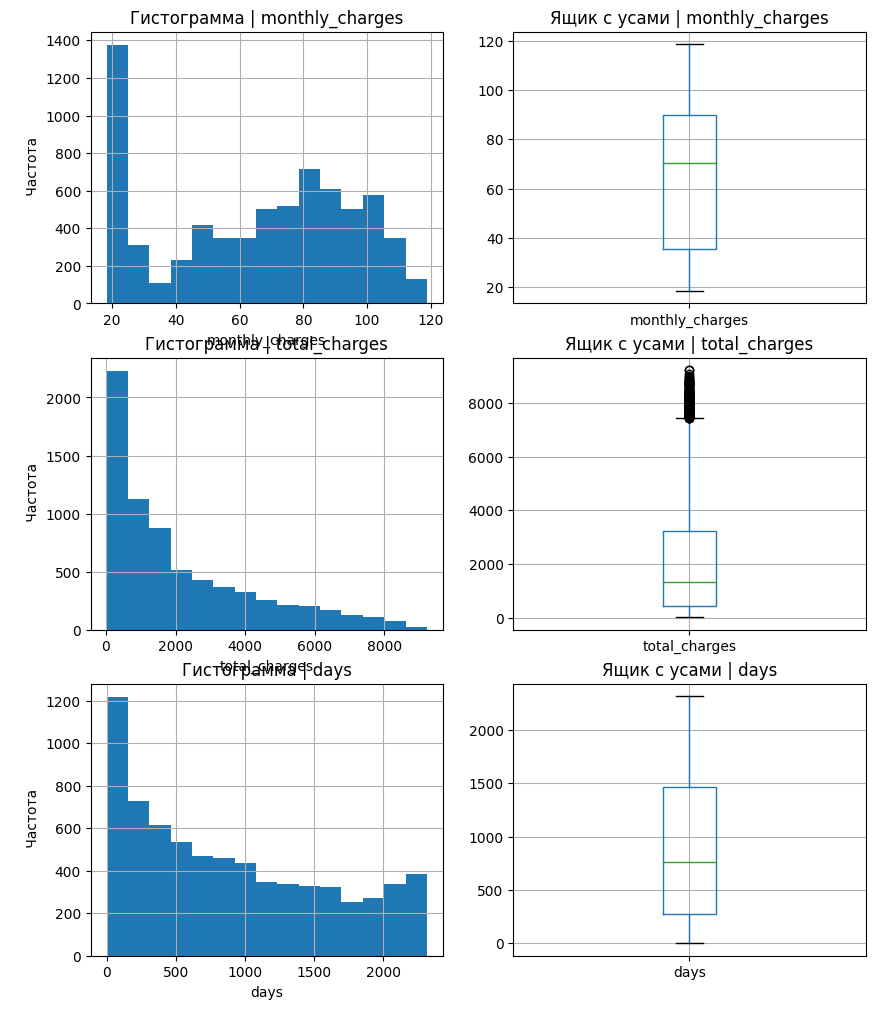

In [187]:
hist_box_plot(data, num_columns)

[]

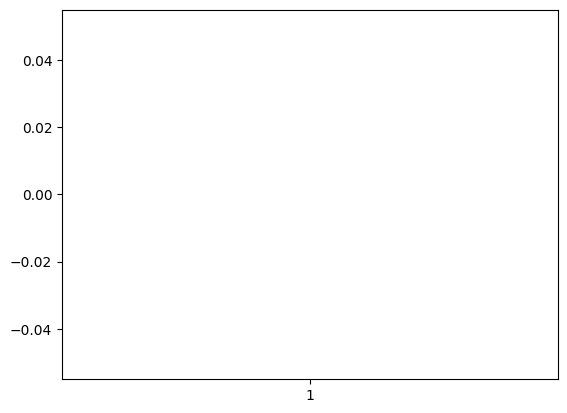

In [188]:
box = plt.boxplot(data['total_charges'])
outliers = list(box['fliers'][0].get_data()[1])
outliers

Прошу подскажи я же правильно понимаю что исходя из графика выбросов нет? Я просто помню как ты говорил что будут значения которые будут казаться выбрсами но это клиенты которые очень давно заключили контракт

### Построим графики для категоральных столбцов

In [189]:
cat = ['type',
    'paperless_billing',
    'payment_method',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies', 
    'multiple_lines'
]

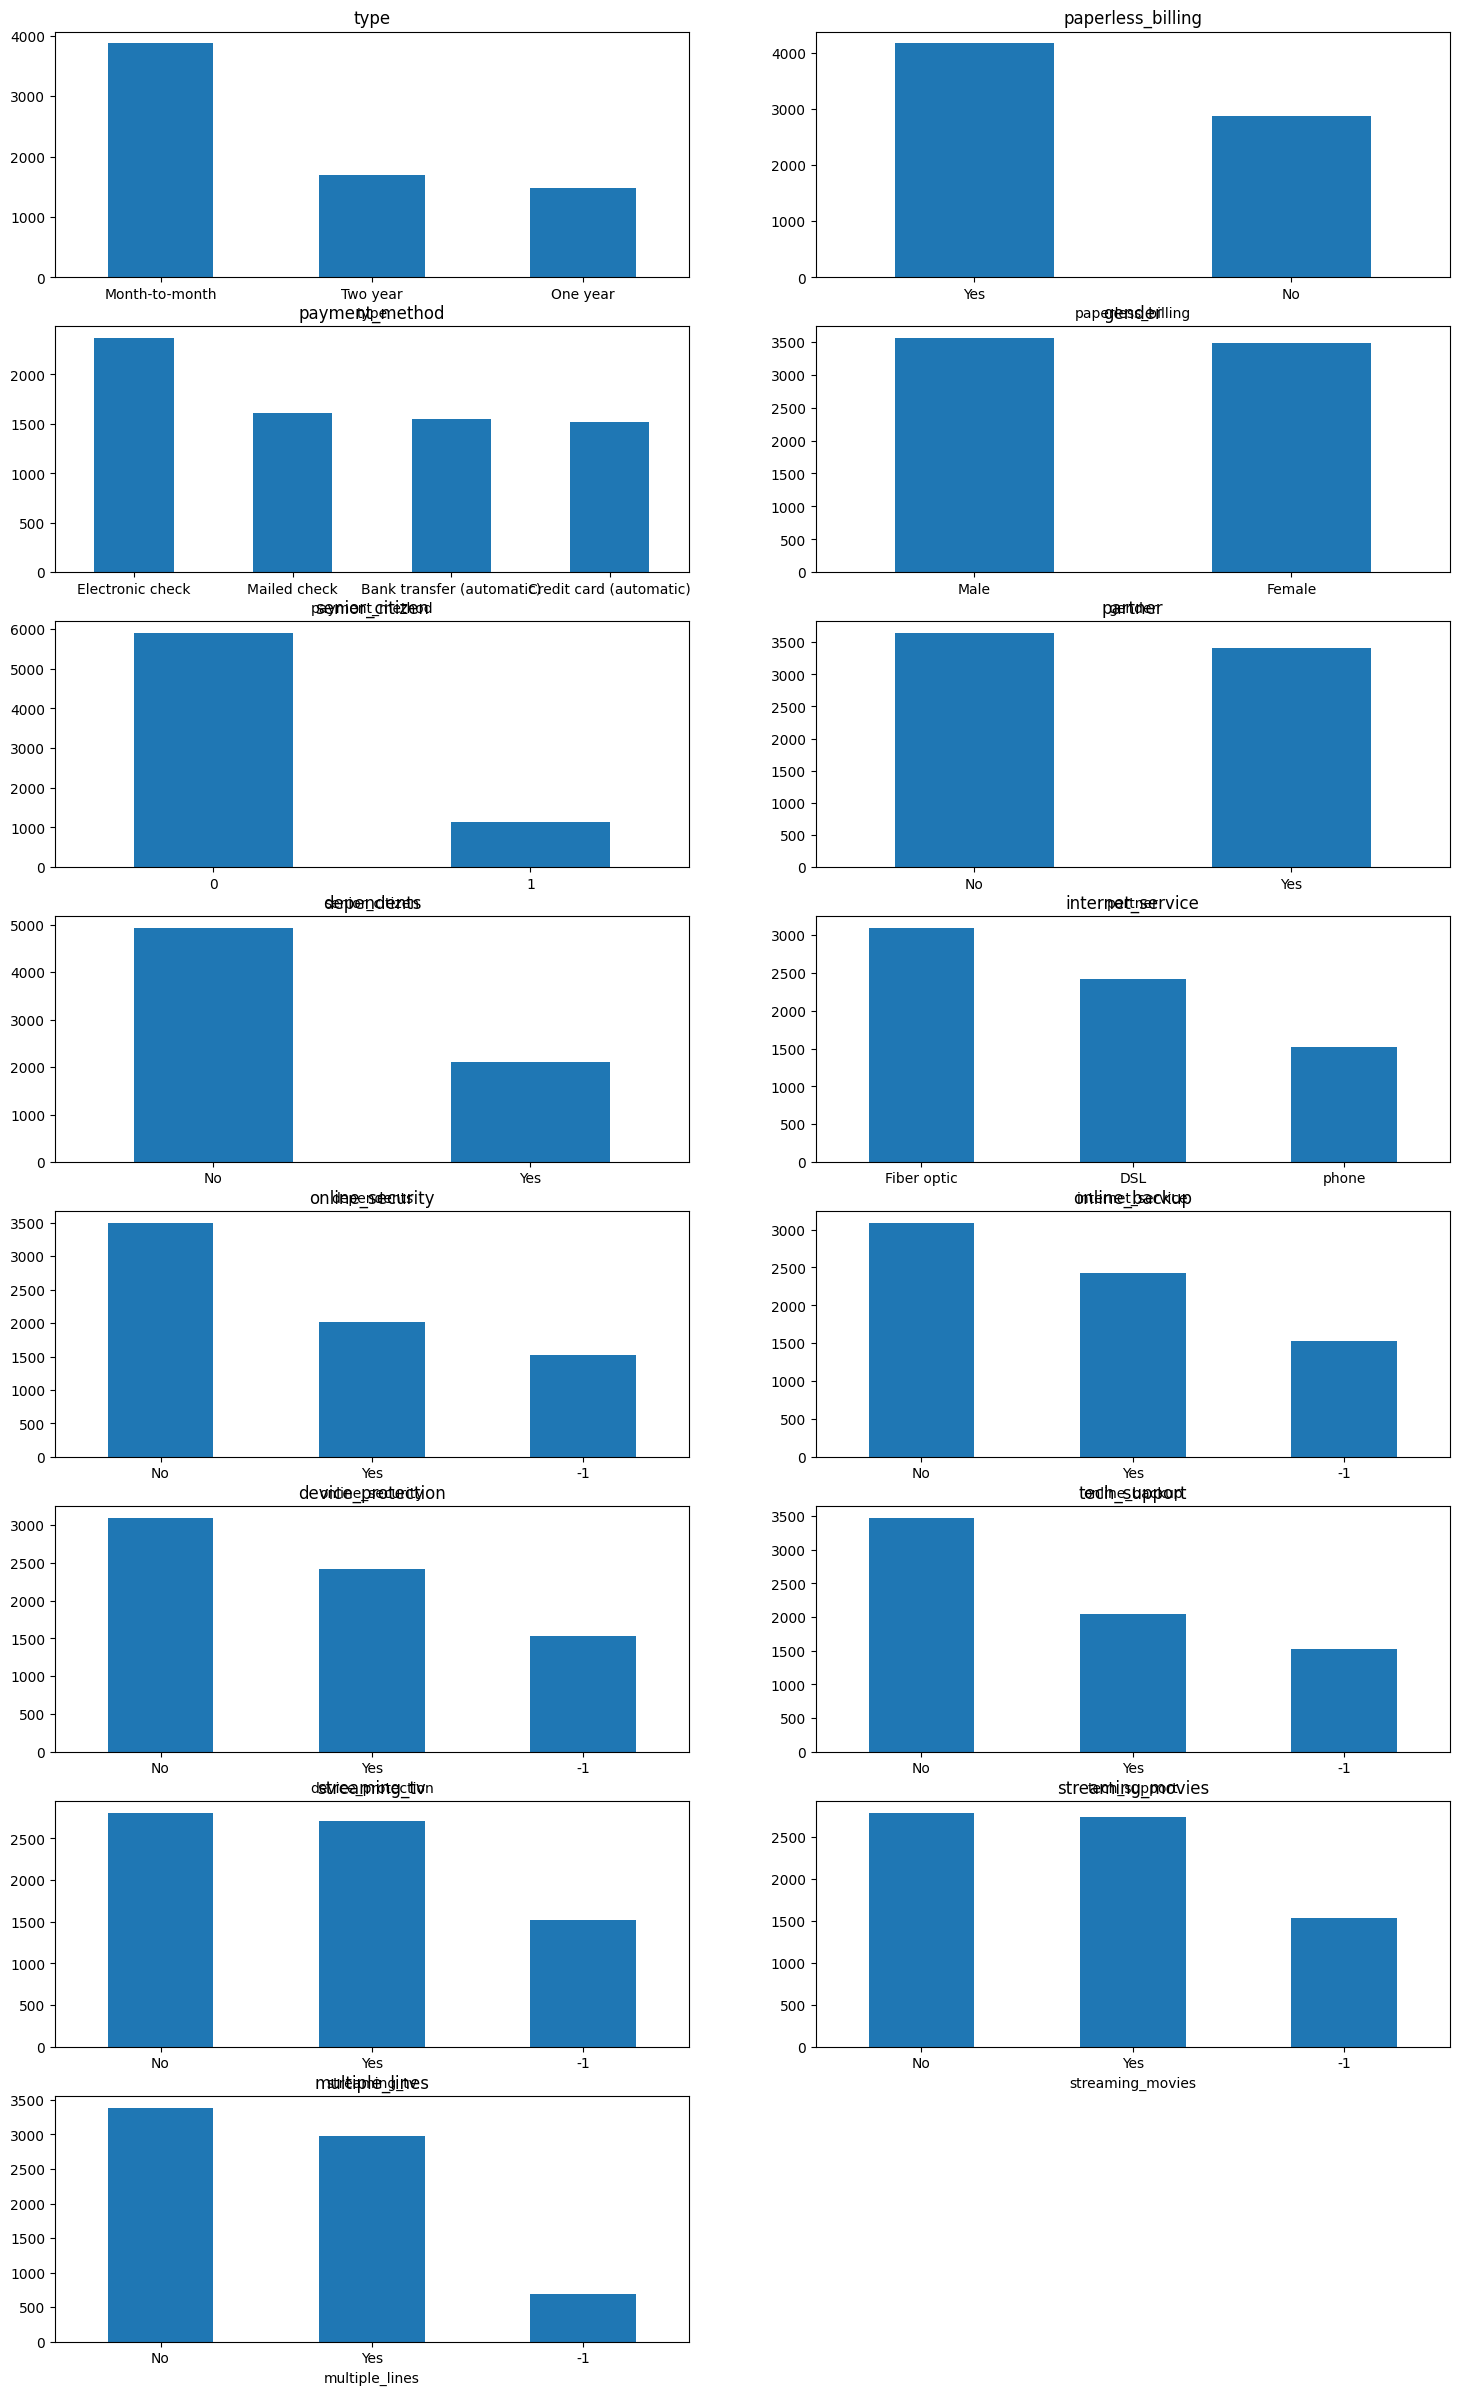

In [190]:
cols = 2
rows = int(np.ceil(len(cat) / cols))

plt.figure(figsize=(18, 30))

for idx, column in enumerate(cat):
    ax = plt.subplot(rows, cols, idx + 1)
    
    data[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
    )
        
plt.show()

Рассмотрим корреляция между у количественных признаков

In [191]:
data[num_columns].corr()

,monthly_charges,total_charges,days
monthly_charges,1.000000,0.630297,0.220054
total_charges,0.630297,1.000000,0.821442
days,0.220054,0.821442,1.000000


interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'still_active', 'days']


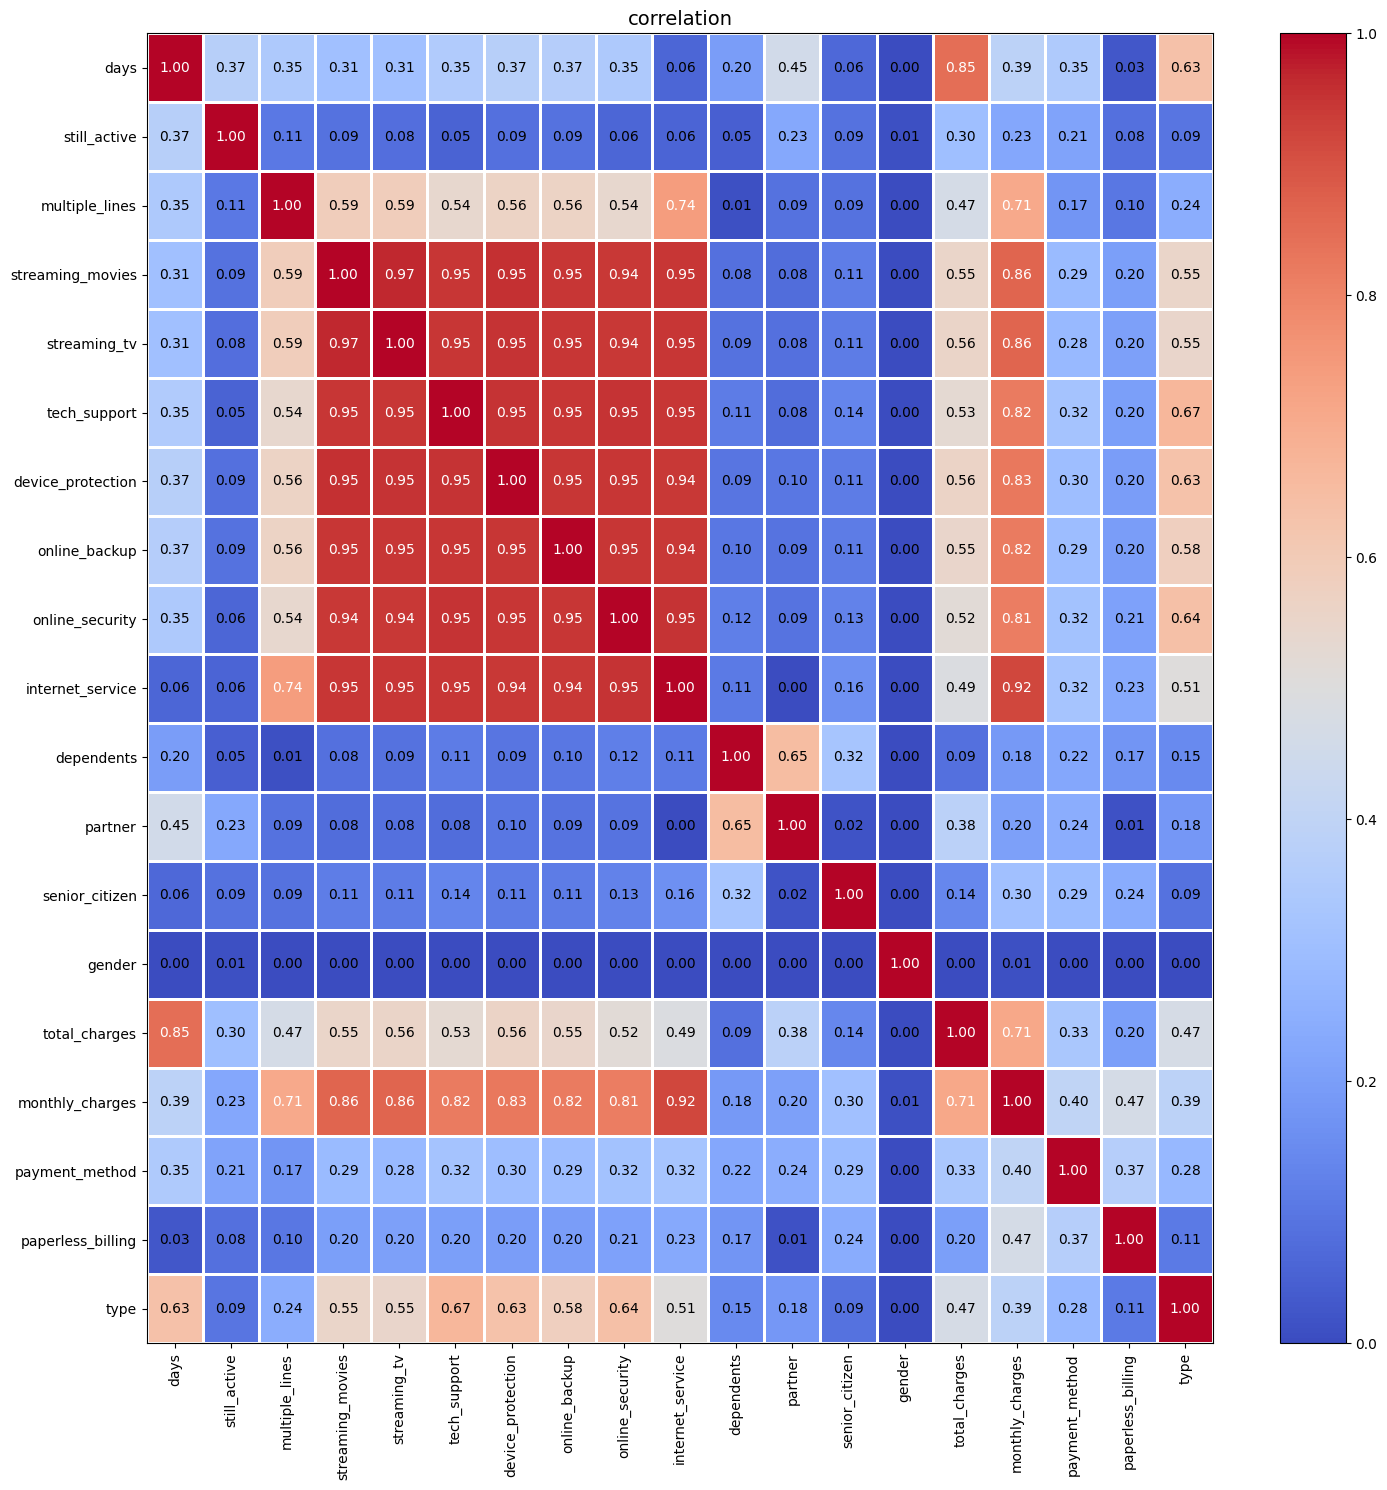

In [192]:
phik_m = data.phik_matrix()

plot_correlation_matrix(
    phik_m.values,
    x_labels=phik_m.columns,
    y_labels=phik_m.index,
    vmin=0, vmax=1, color_map='coolwarm',
    figsize=(15, 15)
)
plt.show()

### Промежуточный вывод

Наибольшая корреляция между параметрами, которые относятся к Интернет-подключению:

    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies'

Наименьшая корреляция у полового признака. 

У целового признака наибольшая корреляция с продолжительностью контракта

И соответсвенно на прибыль больше всего влияют услуги связанные с интернетом

## Подготовка данных

In [193]:
X = data.drop('still_active', axis=1)

y = data['still_active']

In [194]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    stratify=y,
    random_state = RANDOM_STATE
)

In [195]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False)

In [196]:
cols_ohe = ['type', 'paperless_billing', 'payment_method',
        'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']

In [198]:
X_train.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'days'],
      dtype='object')

In [202]:
data_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False), cols_ohe),
    ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), num_columns),
    ],
    remainder='drop'
)

In [203]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', SVC(probability=True, random_state=RANDOM_STATE))
])

## Обучение моделей машинного обучения

In [204]:
param_grid = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 21, 2),
        'model__max_features': range(2, 21, 2),
        'model__criterion': ['gini', 'entropy']
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 21, 2),
        'model__max_features': range(2, 21, 2),
        'model__criterion': ['gini', 'entropy']
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(2, 25),
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)],
        'model__C': [0.1, 1.0, 10.0, 100.0],
    },
    {
        'model': [SVC(probability=True, random_state=RANDOM_STATE)],
        'model__kernel': ['linear', 'rbf'],
        'model__C': [0.1, 1.0, 10.0],
        'model__gamma': ['scale', 'auto']
    },
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(-10, 10, 2),
        'model__learning_rate': [0.01, 0.1, 1, 10]
    },
    {
        'model': [CatBoostClassifier(loss_function='Logloss', random_seed=RANDOM_STATE, silent=True)],
        'model__depth': [x for x in range(1,5)],
        'model__iterations': [x for x in range(100,1100, 100)],
        'model__learning_rate': [0.5, 0.6, 0.7]
    }    
]

In [205]:
random_CV = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    random_state=RANDOM_STATE,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
random_CV.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', random_CV.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', random_CV.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                        

### Промежуточный вывод

Кросс валидацию которую нам показал RandomizedSearchCV проходит по заданному тз перейдем к выбору лучше модели

## Выбор лучшей модели

In [206]:
result = pd.DataFrame(random_CV.cv_results_)
display(result[
    ['rank_test_score', 'param_model', 'mean_test_score', 'params']
].sort_values('rank_test_score').head(10))

,rank_test_score,param_model,mean_test_score,params
2,1,<catboost.core.CatBoostClassifier object at 0x00000266BF5800D0>,0.907497,"{'model__learning_rate': 0.6, 'model__iterations': 1000, 'model__depth': 3, 'model': <catboost.c..."
0,2,<catboost.core.CatBoostClassifier object at 0x00000266BF5800D0>,0.852237,"{'model__learning_rate': 0.6, 'model__iterations': 600, 'model__depth': 1, 'model': <catboost.co..."
1,3,<catboost.core.CatBoostClassifier object at 0x00000266BF5800D0>,0.845597,"{'model__learning_rate': 0.6, 'model__iterations': 300, 'model__depth': 1, 'model': <catboost.co..."
6,4,<catboost.core.CatBoostClassifier object at 0x00000266BF5800D0>,0.837783,"{'model__learning_rate': 0.5, 'model__iterations': 100, 'model__depth': 1, 'model': <catboost.co..."
5,5,RandomForestClassifier(random_state=300924),0.820996,"{'model__max_features': 12, 'model__max_depth': 14, 'model__criterion': 'entropy', 'model': Rand..."
3,6,RandomForestClassifier(random_state=300924),0.820597,"{'model__max_features': 18, 'model__max_depth': 16, 'model__criterion': 'gini', 'model': RandomF..."
8,7,DecisionTreeClassifier(random_state=300924),0.767161,"{'model__max_features': 20, 'model__max_depth': 6, 'model__criterion': 'gini', 'model': Decision..."
9,8,DecisionTreeClassifier(random_state=300924),0.725668,"{'model__max_features': 10, 'model__max_depth': 10, 'model__criterion': 'entropy', 'model': Deci..."
4,9,DecisionTreeClassifier(random_state=300924),0.685083,"{'model__max_features': 18, 'model__max_depth': 12, 'model__criterion': 'gini', 'model': Decisio..."
7,10,DecisionTreeClassifier(random_state=300924),0.615509,"{'model__max_features': 4, 'model__max_depth': 16, 'model__criterion': 'gini', 'model': Decision..."


Исходя из таблицы представленной выше можно сказать что лучшей моделью будет катбуст проверим его на тестовой выборке.

In [207]:
y_test_pred = random_CV.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.918818059464089


In [208]:
importance = pd.DataFrame(random_CV.best_estimator_[-1].feature_importances_,
                         index = random_CV.best_estimator_[:-1].get_feature_names_out(), 
                         columns=['importance']).sort_values('importance', ascending=False)
importance

,importance
num__days,44.599404
num__monthly_charges,15.984713
num__total_charges,13.420074
ohe__type_Two year,2.830559
ohe__partner_Yes,2.563431
ohe__type_One year,1.804578
ohe__dependents_Yes,1.435149
ohe__payment_method_Mailed check,1.427296
ohe__gender_Male,1.341868
ohe__online_backup_Yes,1.289835


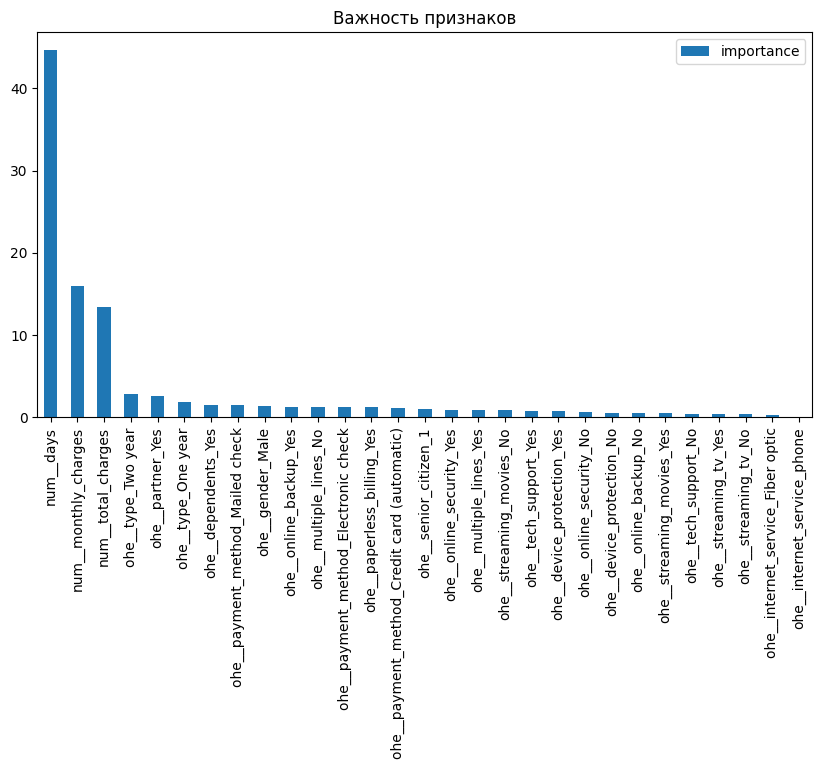

In [209]:
importance.plot(kind='bar', figsize=(10, 5), title='Важность признаков')
plt.show()

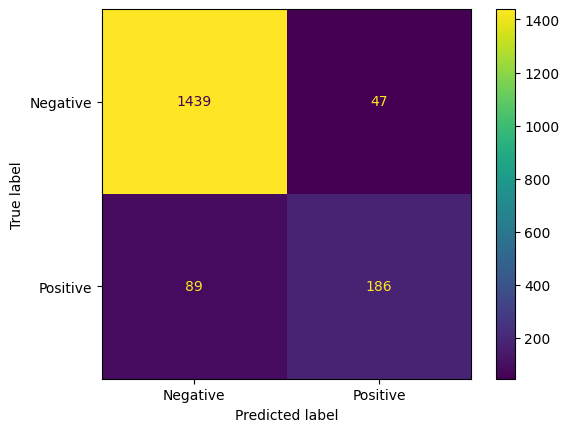

In [215]:
cm = confusion_matrix(y_test, random_CV.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.show()

### Промежуточный вывод

Лучшей моделью для нас является catboost.

С параметрами:

        model__learning_rate = 0.6
        model__iterations = 1000
        model__depth = 3

Модель показала лучше результат на тестовой выборке чем на тренировочной.

Было выявлено что самым важным признаком является количество дней с момента составления договора.

Анализ матрицы ошибок показывает, что протестированная модель правильно предсказывает большую часть класса 0 (на графике горизонталь «Negative», договор не расторгнут). 

Ошибки в этом случае составляют около 3%. Значительно хуже обстоят дела с предсказанием класса 1 (на графике горизонталь «Positive», договор расторгнут). 

Здесь правильно предсказано только 67% всех значений.

Модель эффективно предскажет пользователя, который не собирается расторгать договор, но только 67% случаях правильно предскажет(если расчитаем recall) будет ли пользователь расторгать договор.

## Общий вывод и рекомендации заказчику

В ходе работы были выполнены следующие шаги:

    1) Первоначальный анализ загруженных таблиц
    2) Объедение таблиц
    3) Анализ объеденных таблиц и заполнение пропусков которые возникли в ходе Объедения
    4) Проверили корреляцию данных 
    5) Нашли лучшую модель и подобрали ее гипер параметры (я конечно хотел сделать все внутри пайплайна но увы не получилось)


Итоговой модель получилась catboost.

С параметрами:

        model__learning_rate = 0.6
        model__iterations = 1000
        model__depth = 3

С данными паратмерами метрика ROC-AUC = 0.8974256698886577

Модель обучалась на следующих признаках:
    
    Категориальные признаки:

        type  - тип оплаты: раз в год-два или ежемесячно;
        paperless_billing - электронный расчётный лист;
        payment_method - тип платежа;
        gender - пол;
        senior_citizen - является ли абонент пенсионером;
        partner - есть ли у абонента супруг или супруга;
        dependents - есть ли у абонента дети.
        internet_service - тип подключения;
        online_security - блокировка опасных сайтов;
        online_backup - облачное хранилище файлов для резервного копирования данных;
        device_protection - антивирус;
        tech_support - выделенная линия технической поддержки;
        streaming_tv - стриминговое телевидение;
        streaming_movies - каталог фильмов.
        multiple_lines - подключение телефона к нескольким линиям одновременно.

    Количественные:
        
        monthly_charges - расходы за месяц;
        total_charges - общие расходы абонента.
        days - количество дней которые договора.
    
    Целевой признаки:
        
        still_active - Он указывает на наличие или отсутствие действующего договора с клиентом